# Nasdaq Composite Feature Engineering
In this notebook we take the Nasdaq Composite data and create several new features for each date that include the evolution of closing price during the previous year

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data has been obtained from the following URL: https://finance.yahoo.com/quote/%5EIXIC/history?period1=1451606400&period2=1632614400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [2]:
#we are loading the data from 01/01/2015 to 26/09/2021
nas_hist = pd.read_csv('./data_orig/Nasdaq_Comp.csv')

In [3]:
#We check to see if there are some missing values

nas_hist[nas_hist.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


In [4]:
nas_hist.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,4726.810059,1435150000
1,2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,4652.569824,1794470000
2,2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,4592.740234,2167320000
3,2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,4650.470215,1957950000
4,2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,4736.189941,2105450000
5,2015-01-09,4744.470215,4744.709961,4681.240234,4704.069824,4704.069824,1715830000
6,2015-01-12,4714.069824,4715.810059,4650.649902,4664.709961,4664.709961,1861960000
7,2015-01-13,4708.740234,4751.339844,4624.279785,4661.500000,4661.500000,2162180000
8,2015-01-14,4610.759766,4655.370117,4595.979980,4639.319824,4639.319824,2073810000
9,2015-01-15,4657.459961,4663.959961,4567.390137,4570.819824,4570.819824,1976260000


In [5]:
#we create a copy of the data so as not to change the original
nas_hist_m=nas_hist.copy()

In [6]:
#We change the column Date into a date format
nas_hist_m['Date']=pd.to_datetime(arg=nas_hist_m['Date'],format='%Y-%m-%d')

In [7]:
#Erasing unnecesary columns
nas_hist_m = nas_hist_m.drop(labels=['Open','High','Low','Adj Close','Volume'], axis=1)

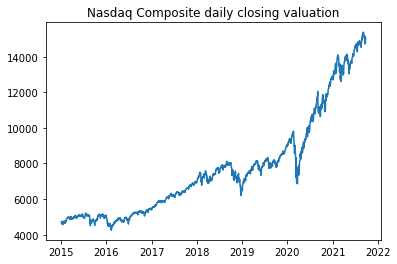

In [9]:
#Let's take a look at the data
plt.plot(nas_hist_m['Date'], nas_hist_m['Close'])
plt.title("Nasdaq Composite daily closing valuation")
plt.show()

In [15]:
#we add cloumns with price variation, from 1 day before, 1 week and 1 year
nas_hist_m['C_dia_ant'] = nas_hist_m['Close'].shift(1)
nas_hist_m['C_dia_ant'].loc[[0]]=nas_hist_m['C_dia_ant'][1]

nas_hist_m['var_dia_ant']=nas_hist_m['Close']/nas_hist_m['C_dia_ant']-1


nas_hist_m['C_sem_ant'] = nas_hist_m['Close'].shift(5)

for i in range(0,5):
    nas_hist_m['C_sem_ant'].loc[[i]]=nas_hist_m['C_sem_ant'][i+5]

nas_hist_m['var_sem_ant']=nas_hist_m['Close']/nas_hist_m['C_sem_ant']-1


nas_hist_m['C_mes_ant'] = nas_hist_m['Close'].shift(20)

for i in range(0,20):
    nas_hist_m['C_mes_ant'].loc[[i]]=nas_hist_m['C_mes_ant'][i+20]

nas_hist_m['var_mes_ant']=nas_hist_m['Close']/nas_hist_m['C_mes_ant']-1

/home/dsc/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [16]:
#We create the real dataset for classification algorithms. It will contain:
#day-to-day price variation of the last 30 days
#day-to-day volume variation of the last 30 days
#week-to-week price variation from 4 weeks before to 12 weeks before
#month-to-month price variation from 3 months before to 11 months before
#if the price went up (1) o not (0) the next day. This is what we are trying to predict
#all this data starting 2015/12/29
#2015/12/29 is a date chosen to make sure we have data before 2016/1/1 and use it as data for 2016/1/1
#in order to be able to merge bitcoin and nasdaq data

columnasData=['varP0', 'varP1', 'varP2', 'varP3', 'varP4', 'varP5', 'varP6', 'varP7', 'varP8', 'varP9',
             'varP10', 'varP11', 'varP12', 'varP13', 'varP14', 'varP15', 'varP16', 'varP17', 'varP18', 'varP19',
             'varPs20', 'varPs25', 'varPs30', 'varPs35', 'varPs40', 'varPs45', 'varPs50', 'varPs55', 'varPs60',
             'varPm65', 'varPm85', 'varPm105', 'varPm125', 'varPm145', 'varPm165', 'varPm185', 'varPm205',
             'varPm225']
data_for_use = pd.DataFrame(columns=columnasData)


for i in range(0,nas_hist_m.shape[0]-1):
    if nas_hist_m['Date'][i]>pd.to_datetime(arg='2015-12-28',format='%Y-%m-%d'):
        #We fill the dates with no nasdaq data with the data from the previous day with data
        if nas_hist_m['Date'][i]>pd.to_datetime(arg='2015-12-31',format='%Y-%m-%d') and \
            (nas_hist_m['Date'].loc[[i]].reset_index(drop=True)-pd.Timedelta(days=1) > \
            nas_hist_m['Date'].loc[[i-1]].reset_index(drop=True)).all():
            
            j=1
            while (nas_hist_m['Date'].loc[[i]].reset_index(drop=True)-pd.Timedelta(days=j) \
                > nas_hist_m['Date'].loc[[i-1]].reset_index(drop=True)).all():
                
                dtemp = dtemp.set_index(keys=[nas_hist_m['Date'].loc[[i-1]]+pd.Timedelta(days=j)])
                data_for_use = data_for_use.append(dtemp)
                j=j+1
        
        
        dtemp = pd.concat([pd.DataFrame(nas_hist_m['var_dia_ant'][i-19:i+1][::-1].values),
                            pd.DataFrame(nas_hist_m['var_sem_ant'][i-64:i-19][::-5].values),
                            pd.DataFrame(nas_hist_m['var_mes_ant'][i-244:i-64][::-20].values)],
                          ignore_index=True, axis=0).T

        dtemp = dtemp.set_index(keys=[nas_hist_m['Date'].loc[[i]]])
        
        new_cols = {x: y for x, y in zip(dtemp.columns, data_for_use.columns)}

        dtemp = dtemp.rename(columns=new_cols)

        data_for_use = data_for_use.append(dtemp)

In [17]:
data_for_use.head(20)

,varP0,varP1,varP2,varP3,varP4,varP5,varP6,varP7,varP8,varP9,...,varPs60,varPm65,varPm85,varPm105,varPm125,varPm145,varPm165,varPm185,varPm205,varPm225
2015-12-29,0.013281,-0.001486,0.000507,0.008962,0.006478,0.009311,-0.015886,-0.013524,0.015168,0.008709,...,0.004541,-0.026224,-0.061627,0.023071,-0.016887,0.032373,0.005926,-0.006517,0.041742,0.001733
2015-12-30,-0.008240,0.013281,-0.001486,0.000507,0.008962,0.006478,0.009311,-0.015886,-0.013524,0.015168,...,0.052221,-0.058892,-0.058491,0.023770,-0.009865,0.028352,-0.006298,0.018731,0.028307,0.004664
2015-12-31,-0.011536,-0.008240,0.013281,-0.001486,0.000507,0.008962,0.006478,0.009311,-0.015886,-0.013524,...,0.051145,-0.054263,-0.066245,0.024728,-0.015097,0.024855,-0.005834,0.025695,0.013013,0.026353
2016-01-01,-0.011536,-0.008240,0.013281,-0.001486,0.000507,0.008962,0.006478,0.009311,-0.015886,-0.013524,...,0.051145,-0.054263,-0.066245,0.024728,-0.015097,0.024855,-0.005834,0.025695,0.013013,0.026353
2016-01-02,-0.011536,-0.008240,0.013281,-0.001486,0.000507,0.008962,0.006478,0.009311,-0.015886,-0.013524,...,0.051145,-0.054263,-0.066245,0.024728,-0.015097,0.024855,-0.005834,0.025695,0.013013,0.026353
2016-01-03,-0.011536,-0.008240,0.013281,-0.001486,0.000507,0.008962,0.006478,0.009311,-0.015886,-0.013524,...,0.051145,-0.054263,-0.066245,0.024728,-0.015097,0.024855,-0.005834,0.025695,0.013013,0.026353
2016-01-04,-0.020833,-0.011536,-0.008240,0.013281,-0.001486,0.000507,0.008962,0.006478,0.009311,-0.015886,...,0.037009,-0.003438,-0.091949,0.021629,-0.004813,0.003613,0.001515,0.020986,0.019185,0.029965
2016-01-05,-0.002378,-0.020833,-0.011536,-0.008240,0.013281,-0.001486,0.000507,0.008962,0.006478,0.009311,...,0.039703,-0.025874,-0.075869,0.046882,-0.020764,0.004065,0.001066,0.023911,0.002913,0.047052
2016-01-06,-0.011381,-0.002378,-0.020833,-0.011536,-0.008240,0.013281,-0.001486,0.000507,0.008962,0.006478,...,0.026061,-0.005434,-0.063867,0.027231,-0.030392,0.020196,-0.000221,0.009693,0.007289,0.070670
2016-01-07,-0.030260,-0.011381,-0.002378,-0.020833,-0.011536,-0.008240,0.013281,-0.001486,0.000507,0.008962,...,0.012001,0.020782,-0.071303,0.009172,-0.016687,0.020238,-0.005853,0.014904,0.007789,0.057158


In [18]:
data_for_use.to_csv('./data_proc/nasdaq_data_for_use.csv')